In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Data PreProcessing

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)), 
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
train_dataset = datasets.ImageFolder('./tiny-imagenet-200/train', transform=train_transforms)
train_dir = './tiny-imagenet-200/train'
classes = os.listdir(train_dir)
print("Folders found:", classes)
print("Number of classes:", len(classes))

Folders found: ['n01443537', 'n01629819', 'n01641577', 'n01644900', 'n01698640', 'n01742172', 'n01768244', 'n01770393', 'n01774384', 'n01774750', 'n01784675', 'n01855672', 'n01882714', 'n01910747', 'n01917289', 'n01944390', 'n01945685', 'n01950731', 'n01983481', 'n01984695', 'n02002724', 'n02056570', 'n02058221', 'n02074367', 'n02085620', 'n02094433', 'n02099601', 'n02099712', 'n02106662', 'n02113799', 'n02123045', 'n02123394', 'n02124075', 'n02125311', 'n02129165', 'n02132136', 'n02165456', 'n02190166', 'n02206856', 'n02226429', 'n02231487', 'n02233338', 'n02236044', 'n02268443', 'n02279972', 'n02281406', 'n02321529', 'n02364673', 'n02395406', 'n02403003', 'n02410509', 'n02415577', 'n02423022', 'n02437312', 'n02480495', 'n02481823', 'n02486410', 'n02504458', 'n02509815', 'n02666196', 'n02669723', 'n02699494', 'n02730930', 'n02769748', 'n02788148', 'n02791270', 'n02793495', 'n02795169', 'n02802426', 'n02808440', 'n02814533', 'n02814860', 'n02815834', 'n02823428', 'n02837789', 'n0284131

In [4]:
val_dir = './tiny-imagenet-200/val'
annotation_file = os.path.join(val_dir, 'val_annotations.txt')
new_val_dir = './tiny-imagenet-200/val-images-by-class'
val_dataset = datasets.ImageFolder(new_val_dir, transform=train_transforms)
classes = os.listdir('./tiny-imagenet-200/val-images-by-class')
print(classes)
print(len(classes))

['n01443537', 'n01629819', 'n01641577', 'n01644900', 'n01698640', 'n01742172', 'n01768244', 'n01770393', 'n01774384', 'n01774750', 'n01784675', 'n01855672', 'n01882714', 'n01910747', 'n01917289', 'n01944390', 'n01945685', 'n01950731', 'n01983481', 'n01984695', 'n02002724', 'n02056570', 'n02058221', 'n02074367', 'n02085620', 'n02094433', 'n02099601', 'n02099712', 'n02106662', 'n02113799', 'n02123045', 'n02123394', 'n02124075', 'n02125311', 'n02129165', 'n02132136', 'n02165456', 'n02190166', 'n02206856', 'n02226429', 'n02231487', 'n02233338', 'n02236044', 'n02268443', 'n02279972', 'n02281406', 'n02321529', 'n02364673', 'n02395406', 'n02403003', 'n02410509', 'n02415577', 'n02423022', 'n02437312', 'n02480495', 'n02481823', 'n02486410', 'n02504458', 'n02509815', 'n02666196', 'n02669723', 'n02699494', 'n02730930', 'n02769748', 'n02788148', 'n02791270', 'n02793495', 'n02795169', 'n02802426', 'n02808440', 'n02814533', 'n02814860', 'n02815834', 'n02823428', 'n02837789', 'n02841315', 'n02843684'

In [5]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)

# VGG16 Model Implementation

In [28]:
# Load a pre-trained VGG16 model
num_classes = 200           # Tiny ImageNet has 200 classes
learning_rate = 0.01
model = models.vgg16(weights='IMAGENET1K_V1')

# Modify the final fully connected layer to match the number of classes in Tiny ImageNet
for idx, layer in enumerate(model.features):
    if idx < 10:  # adjust this threshold based on your experiments
        for param in layer.parameters():
            param.requires_grad = False
    else:
        for param in layer.parameters():
            param.requires_grad = True

model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
model = model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


# Training Loop

In [29]:
# Initialize lists to store the losses per epoch
train_losses = []
val_losses = []
train_accs = []
val_accs = []
best_val_loss = float('inf')
patience = 5
trigger_times = 0
num_epochs = 50

for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    
    # Reset loss accumulators for this epoch
    running_train_loss = 0.0
    running_train_corrects = 0

    # Training Phase
    model.train()
    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_train_corrects += torch.sum(preds == labels.data)

    scheduler.step()
    
    # Compute average training loss for the epoch
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    epoch_train_acc = running_train_corrects.float() / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    train_accs.append(epoch_train_acc.item())

    # Validation Phase
    model.eval()
    running_val_loss = 0.0
    running_val_corrects = 0

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_val_corrects += torch.sum(preds == labels.data)
    
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    epoch_val_acc = running_val_corrects.float() / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    val_accs.append(epoch_val_acc.item())
    
    print(f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.4f}")
    print(f"Val Loss: {epoch_val_loss:.4f}   | Val Acc: {epoch_val_acc:.4f}")
    print('-' * 30)

    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        trigger_times = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        trigger_times += 1
        if trigger_times > patience:
            print("Early stopping")
            break


Epoch 1/50


Validation: 100%|██████████| 157/157 [00:11<00:00, 13.56it/s]


Train Loss: 3.4519 | Train Acc: 0.2424
Val Loss: 2.8564   | Val Acc: 0.3479
------------------------------
Epoch 2/50


Validation: 100%|██████████| 157/157 [00:11<00:00, 13.38it/s]


Train Loss: 2.8969 | Train Acc: 0.3382
Val Loss: 2.6828   | Val Acc: 0.3741
------------------------------
Epoch 3/50


Validation: 100%|██████████| 157/157 [00:11<00:00, 13.54it/s]


Train Loss: 2.7086 | Train Acc: 0.3748
Val Loss: 2.6727   | Val Acc: 0.3880
------------------------------
Epoch 4/50


Validation: 100%|██████████| 157/157 [00:11<00:00, 13.59it/s]


Train Loss: 2.6034 | Train Acc: 0.3959
Val Loss: 2.5052   | Val Acc: 0.4131
------------------------------
Epoch 5/50


Validation: 100%|██████████| 157/157 [00:11<00:00, 13.61it/s]


Train Loss: 2.5089 | Train Acc: 0.4138
Val Loss: 2.4938   | Val Acc: 0.4124
------------------------------
Epoch 6/50


Validation: 100%|██████████| 157/157 [00:11<00:00, 13.47it/s]


Train Loss: 2.4355 | Train Acc: 0.4286
Val Loss: 2.5454   | Val Acc: 0.4095
------------------------------
Epoch 7/50


Validation: 100%|██████████| 157/157 [00:11<00:00, 13.40it/s]


Train Loss: 2.3764 | Train Acc: 0.4404
Val Loss: 2.4863   | Val Acc: 0.4205
------------------------------
Epoch 8/50


Validation: 100%|██████████| 157/157 [00:11<00:00, 13.56it/s]


Train Loss: 2.3395 | Train Acc: 0.4481
Val Loss: 2.4798   | Val Acc: 0.4274
------------------------------
Epoch 9/50


Validation: 100%|██████████| 157/157 [00:11<00:00, 13.64it/s]


Train Loss: 2.2914 | Train Acc: 0.4574
Val Loss: 2.4006   | Val Acc: 0.4378
------------------------------
Epoch 10/50


Validation: 100%|██████████| 157/157 [00:11<00:00, 13.51it/s]


Train Loss: 2.2697 | Train Acc: 0.4635
Val Loss: 2.4235   | Val Acc: 0.4399
------------------------------
Epoch 11/50


Validation: 100%|██████████| 157/157 [00:12<00:00, 13.02it/s]


Train Loss: 1.8923 | Train Acc: 0.5415
Val Loss: 2.0985   | Val Acc: 0.5082
------------------------------
Epoch 12/50


Validation: 100%|██████████| 157/157 [00:11<00:00, 13.60it/s]


Train Loss: 1.7693 | Train Acc: 0.5684
Val Loss: 2.0805   | Val Acc: 0.5085
------------------------------
Epoch 13/50


Validation: 100%|██████████| 157/157 [00:11<00:00, 13.55it/s]


Train Loss: 1.7307 | Train Acc: 0.5776
Val Loss: 2.0426   | Val Acc: 0.5169
------------------------------
Epoch 14/50


Validation: 100%|██████████| 157/157 [00:11<00:00, 13.44it/s]


Train Loss: 1.6855 | Train Acc: 0.5877
Val Loss: 2.0437   | Val Acc: 0.5188
------------------------------
Epoch 15/50


Validation: 100%|██████████| 157/157 [00:11<00:00, 13.43it/s]


Train Loss: 1.6550 | Train Acc: 0.5946
Val Loss: 2.0352   | Val Acc: 0.5234
------------------------------
Epoch 16/50


Validation: 100%|██████████| 157/157 [00:11<00:00, 13.51it/s]


Train Loss: 1.6308 | Train Acc: 0.5998
Val Loss: 2.0181   | Val Acc: 0.5246
------------------------------
Epoch 17/50


Validation: 100%|██████████| 157/157 [00:11<00:00, 13.44it/s]


Train Loss: 1.6077 | Train Acc: 0.6052
Val Loss: 1.9913   | Val Acc: 0.5311
------------------------------
Epoch 18/50


Validation: 100%|██████████| 157/157 [00:11<00:00, 13.50it/s]


Train Loss: 1.5864 | Train Acc: 0.6113
Val Loss: 2.0084   | Val Acc: 0.5229
------------------------------
Epoch 19/50


Validation: 100%|██████████| 157/157 [00:11<00:00, 13.49it/s]


Train Loss: 1.5724 | Train Acc: 0.6122
Val Loss: 1.9798   | Val Acc: 0.5318
------------------------------
Epoch 20/50


Validation: 100%|██████████| 157/157 [00:11<00:00, 13.51it/s]


Train Loss: 1.5565 | Train Acc: 0.6160
Val Loss: 1.9954   | Val Acc: 0.5285
------------------------------
Epoch 21/50


Validation: 100%|██████████| 157/157 [00:11<00:00, 13.46it/s]


Train Loss: 1.5059 | Train Acc: 0.6272
Val Loss: 1.9565   | Val Acc: 0.5393
------------------------------
Epoch 22/50


Validation: 100%|██████████| 157/157 [00:11<00:00, 13.50it/s]


Train Loss: 1.4975 | Train Acc: 0.6280
Val Loss: 1.9768   | Val Acc: 0.5405
------------------------------
Epoch 23/50


Validation: 100%|██████████| 157/157 [00:11<00:00, 13.52it/s]


Train Loss: 1.5012 | Train Acc: 0.6298
Val Loss: 1.9448   | Val Acc: 0.5383
------------------------------
Epoch 24/50


Validation: 100%|██████████| 157/157 [00:11<00:00, 13.40it/s]


Train Loss: 1.4893 | Train Acc: 0.6327
Val Loss: 1.9524   | Val Acc: 0.5417
------------------------------
Epoch 25/50


Validation: 100%|██████████| 157/157 [00:11<00:00, 13.39it/s]


Train Loss: 1.4826 | Train Acc: 0.6327
Val Loss: 1.9628   | Val Acc: 0.5390
------------------------------
Epoch 26/50


Validation: 100%|██████████| 157/157 [00:11<00:00, 13.44it/s]


Train Loss: 1.4784 | Train Acc: 0.6334
Val Loss: 1.9442   | Val Acc: 0.5423
------------------------------
Epoch 27/50


Validation: 100%|██████████| 157/157 [00:11<00:00, 13.39it/s]


Train Loss: 1.4873 | Train Acc: 0.6322
Val Loss: 1.9753   | Val Acc: 0.5385
------------------------------
Epoch 28/50


Validation: 100%|██████████| 157/157 [00:11<00:00, 13.52it/s]


Train Loss: 1.4752 | Train Acc: 0.6328
Val Loss: 1.9266   | Val Acc: 0.5467
------------------------------
Epoch 29/50


Validation: 100%|██████████| 157/157 [00:11<00:00, 13.43it/s]


Train Loss: 1.4766 | Train Acc: 0.6351
Val Loss: 1.9802   | Val Acc: 0.5319
------------------------------
Epoch 30/50


Validation: 100%|██████████| 157/157 [00:11<00:00, 13.51it/s]


Train Loss: 1.4792 | Train Acc: 0.6329
Val Loss: 1.9382   | Val Acc: 0.5439
------------------------------
Epoch 31/50


Validation: 100%|██████████| 157/157 [00:11<00:00, 13.41it/s]


Train Loss: 1.4698 | Train Acc: 0.6341
Val Loss: 1.9705   | Val Acc: 0.5400
------------------------------
Epoch 32/50


Validation: 100%|██████████| 157/157 [00:11<00:00, 13.49it/s]


Train Loss: 1.4594 | Train Acc: 0.6373
Val Loss: 1.9386   | Val Acc: 0.5439
------------------------------
Epoch 33/50


Validation: 100%|██████████| 157/157 [00:11<00:00, 13.21it/s]


Train Loss: 1.4645 | Train Acc: 0.6365
Val Loss: 1.9569   | Val Acc: 0.5424
------------------------------
Epoch 34/50


Validation: 100%|██████████| 157/157 [00:11<00:00, 13.41it/s]

Train Loss: 1.4633 | Train Acc: 0.6370
Val Loss: 1.9534   | Val Acc: 0.5431
------------------------------
Early stopping


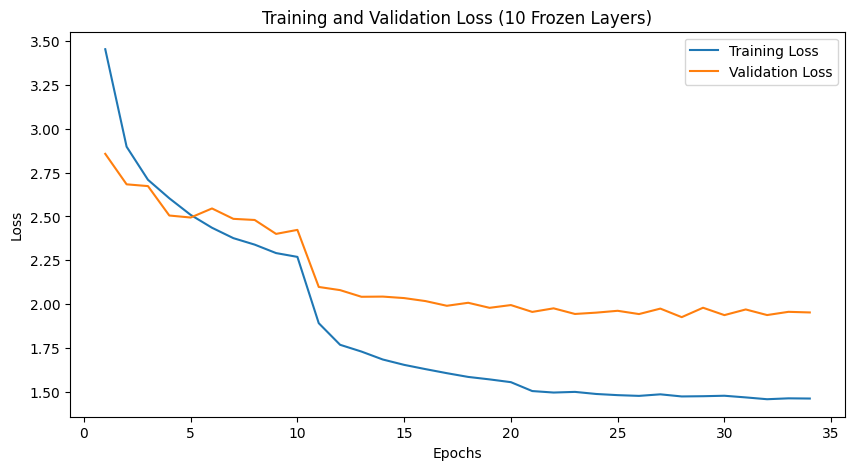

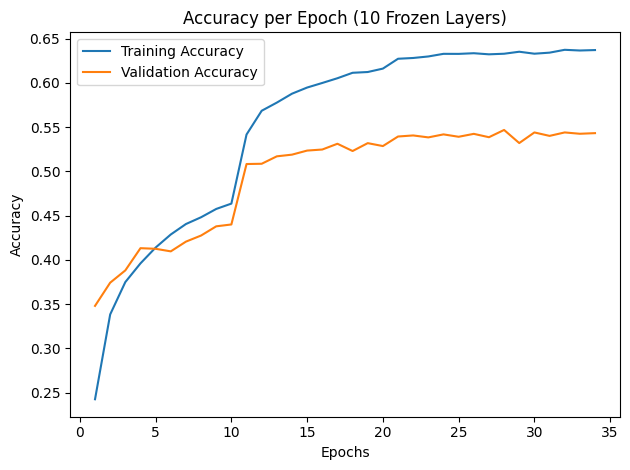

In [31]:
epochs = range(1, 34 + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (10 Frozen Layers)')
plt.legend()
plt.savefig(".01LR.png")
plt.show()

plt.subplot()
plt.plot(epochs, train_accs, label='Training Accuracy')
plt.plot(epochs, val_accs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch (10 Frozen Layers)')
plt.legend()

plt.tight_layout()
plt.savefig(".01LR.png")
plt.show()

# Feature Visualization of Each Layer

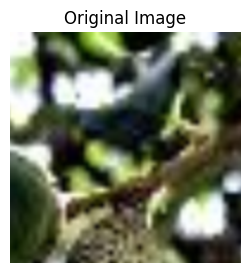

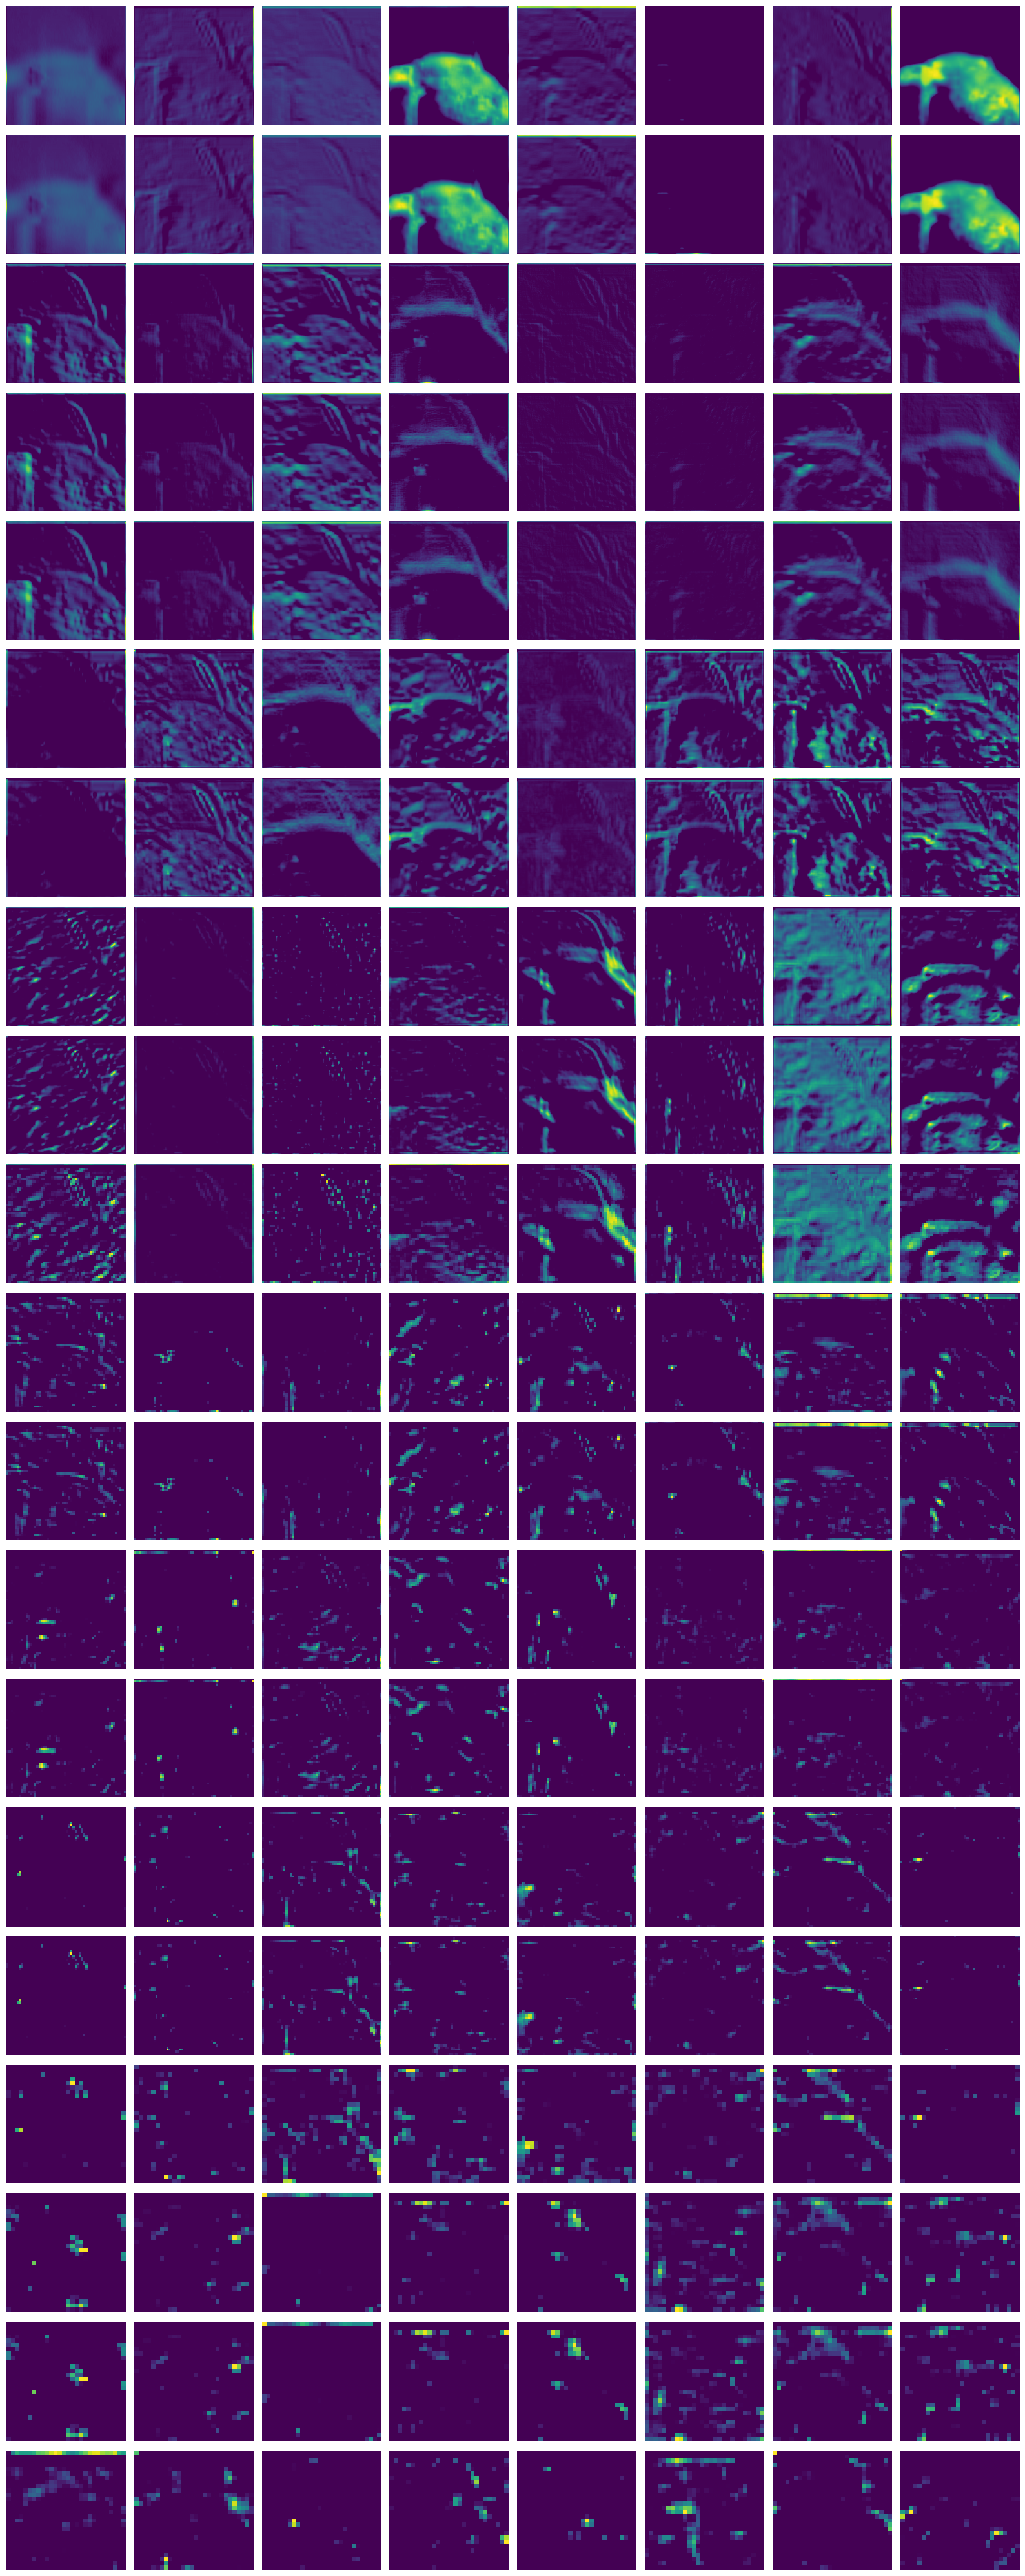

In [35]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

def denormalize(tensor):
    """
    Denormalize a single image tensor of shape [3, H, W].
    """
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    # Clamp to [0, 1] after denormalizing
    return torch.clamp(tensor, 0, 1)

# Take the first image in the batch
image_tensor = inputs[4].cpu().clone()  # shape [3, H, W]
image_tensor = denormalize(image_tensor)
image_np = image_tensor.permute(1, 2, 0).numpy()  # shape [H, W, 3]

plt.figure(figsize=(3, 3))
plt.imshow(image_np)
plt.title("Original Image")
plt.axis('off')
plt.savefig("input-image.png")
plt.show()
# Dictionary to store activations
activations = {}

# Hook function to capture the output of a layer
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# Register hooks on each layer in the VGG16 feature extractor (the convolutional layers)
for idx, layer in enumerate(model.features):
    layer.register_forward_hook(get_activation(f'features_{idx}'))

# Get a sample batch from the validation set (or use a single image)
model.eval()
sample_inputs, _ = next(iter(val_loader))
sample_inputs = sample_inputs.to(device)

# Forward pass to capture activations
_ = model(sample_inputs)

# Visualize the activations for each registered layer for the first image in the batch
max_channels_to_show = 8  # or another small number to keep it readable

# Get a consistent ordering of layers
layer_names = list(activations.keys())
layer_names = layer_names[:20]
num_layers = len(layer_names)

# Create a figure with num_layers rows and max_channels_to_show columns
fig, axes = plt.subplots(
    nrows=num_layers, 
    ncols=max_channels_to_show, 
    figsize=(max_channels_to_show * 2, num_layers * 2)  # adjust as needed
)

# If there's only one row or one column, make 'axes' a 2D list for consistency
if num_layers == 1 and max_channels_to_show == 1:
    # Only one layer, one channel
    axes = [[axes]]
elif num_layers == 1:
    # Only one layer, multiple channels
    axes = [axes]
elif max_channels_to_show == 1:
    # Multiple layers, one channel
    axes = [[ax] for ax in axes]

# Iterate through each layer
for row_idx, layer_name in enumerate(layer_names):
    # Extract the activation for the first image in the batch
    act = activations[layer_name][0].cpu()  # shape: [channels, height, width]
    channels = act.shape[0]

    # Number of channels to display (whichever is smaller: actual channels or max_channels_to_show)
    ncols = min(channels, max_channels_to_show)

    # Plot each channel in a subplot
    for col_idx in range(ncols):
        axes[row_idx][col_idx].imshow(act[col_idx].numpy(), cmap='viridis')
        axes[row_idx][col_idx].axis('off')
        
        # Optionally, add a small label on the leftmost column
        if col_idx == 0:
            axes[row_idx][col_idx].set_ylabel(layer_name, rotation=0, labelpad=40)

    # Hide any unused subplots if act has fewer channels than max_channels_to_show
    for col_idx in range(ncols, max_channels_to_show):
        axes[row_idx][col_idx].axis('off')

plt.tight_layout()
plt.savefig('all_layers_feature_maps.png', dpi=150, bbox_inches='tight')
plt.show()